In [ ]:
!pip install inflect

In [4]:
import pandas as pd
import numpy as np
import inflect
import neural_lib as nl
import matplotlib.pyplot as plt

from frozendict import frozendict
from sklearn.utils import shuffle
from ucimlrepo import fetch_ucirepo 
from fcapy.visualizer import LineVizNx
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from sklearn.model_selection import train_test_split
plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [5]:
import warnings
warnings.filterwarnings('ignore')

## FIRST DATASET

In [6]:
from ucimlrepo import fetch_ucirepo 

wine = fetch_ucirepo(id=109) 
X = wine.data.features 
y = wine.data.targets 

In [7]:
#drop the least target value with corresponding rows, because we can solve only binary problems
#then binarizing the target column

indices_to_drop = y[y == 3].dropna().index

X = X.drop(indices_to_drop)
y = y.drop(indices_to_drop)
y['class'] = y['class'] == 2

In [8]:
#shuffle the whole dataset, picking 129 rows and then sepparate to X and y again
#somehow this helpes to avoid some problems with torch later

combined_df = pd.concat([X, y], axis=1)
shuffled_df = shuffle(combined_df)
selected_df = shuffled_df.iloc[:129]
features_wine = selected_df.drop(columns=['class'], axis=1)
target_wine = selected_df['class']

In [9]:
features_wine

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
77,11.84,2.89,2.23,18.0,112,1.72,1.32,0.43,0.95,2.65,0.960,2.52,500
75,11.66,1.88,1.92,16.0,97,1.61,1.57,0.34,1.15,3.80,1.230,2.14,428
123,13.05,5.80,2.13,21.5,86,2.62,2.65,0.30,2.01,2.60,0.730,3.10,380
105,12.42,2.55,2.27,22.0,90,1.68,1.84,0.66,1.42,2.70,0.860,3.30,315
70,12.29,1.61,2.21,20.4,103,1.10,1.02,0.37,1.46,3.05,0.906,1.82,870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.010,3.55,1045
16,14.30,1.92,2.72,20.0,120,2.80,3.14,0.33,1.97,6.20,1.070,2.65,1280
88,11.64,2.06,2.46,21.6,84,1.95,1.69,0.48,1.35,2.80,1.000,2.75,680
90,12.08,1.83,2.32,18.5,81,1.60,1.50,0.52,1.64,2.40,1.080,2.27,480


In [10]:
target_wine.value_counts()

True     70
False    59
Name: class, dtype: int64

In [11]:
#dropping some features

features_wine = features_wine.drop(columns = ['Ash', 'Alcalinity_of_ash'])

In [12]:
#changing index from integers to strings

p = inflect.engine()

custom_index = [p.number_to_words(i+1).capitalize() for i in range(len(features_wine))]
features_wine.index = custom_index
target_wine.index = custom_index

In [13]:
#binarization by median value of each column

for col in features_wine.columns:
    median_val = features_wine[col].median()
    features_wine.loc[:, col] = features_wine[col] >= median_val

X_train, X_test, y_train, y_test = train_test_split(features_wine, target_wine, test_size=0.3, random_state=42)

In [18]:
K_train = FormalContext(data=X_train.values, target=y_train.values, attribute_names=X_train.columns)
K_train

FormalContext (90 objects, 11 attributes, 485 connections)
  |Alcohol|Malicacid|Magnesium|Total_phenols|Flavanoids|...|Proanthocyanins|Color_intensity|Hue|0D280_0D315_of_diluted_wines|Proline|
0 |      X|        X|        X|            X|         X|...|               |              X|   |                           X|       |
1 |      X|         |         |             |          |...|               |              X|  X|                            |       |
2 |       |         |         |             |          |...|              X|               |  X|                            |       |
3 |       |         |        X|             |          |...|              X|               |  X|                            |      X|
4 |       |        X|         |             |          |...|              X|               |   |                           X|       |
5 |      X|        X|        X|            X|         X|...|               |              X|   |                           X|      X|
6 |

In [21]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

490

In [22]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    f1 = f1_score(y_train, y_preds, average='weighted')
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1
    c.measures = frozendict(updated_measures)

In [34]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:10])

In [35]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [36]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [37]:
descr = {'smooth', 'green', 'oval'}

traced = cn.trace_description(descr, include_targets=False)

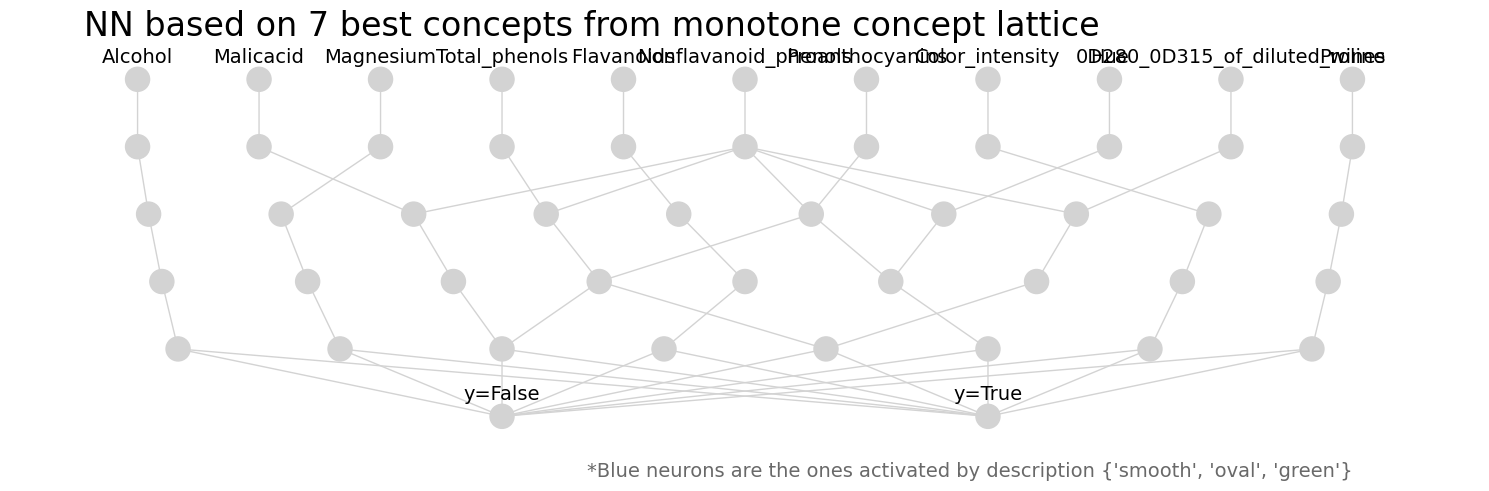

In [38]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [39]:
X_train.shape

(90, 11)

In [40]:
y_train.value_counts()

True     52
False    38
Name: class, dtype: int64

In [41]:
cn.fit(X_train, y_train)

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)
print('f1 score', f1_score(y_test.values, cn.predict(X_test).numpy()))
print('accuracy score', accuracy_score(y_test.values, cn.predict(X_test).numpy()))

Class prediction [0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1
 1 0]
Class prediction with probabilities [[9.9189186e-01 8.1080869e-03]
 [9.9643755e-01 3.5624956e-03]
 [6.4073502e-05 9.9993587e-01]
 [9.9189186e-01 8.1080869e-03]
 [4.2863157e-01 5.7136846e-01]
 [6.4073502e-05 9.9993587e-01]
 [9.9189186e-01 8.1080869e-03]
 [2.8024944e-05 9.9997199e-01]
 [9.9189186e-01 8.1080869e-03]
 [9.9189186e-01 8.1080869e-03]
 [9.9643755e-01 3.5624956e-03]
 [1.0341174e-02 9.8965877e-01]
 [2.4704975e-01 7.5295025e-01]
 [2.4704975e-01 7.5295025e-01]
 [9.9643755e-01 3.5624956e-03]
 [2.8024944e-05 9.9997199e-01]
 [9.9189186e-01 8.1080869e-03]
 [9.9643755e-01 3.5624956e-03]
 [9.9643755e-01 3.5624956e-03]
 [9.9189186e-01 8.1080869e-03]
 [2.8024944e-05 9.9997199e-01]
 [9.9189186e-01 8.1080869e-03]
 [9.9643755e-01 3.5624956e-03]
 [9.9643755e-01 3.5624956e-03]
 [9.9643755e-01 3.5624956e-03]
 [2.8024944e-05 9.9997199e-01]
 [9.9643755e-01 3.5624956e-03]
 [9.9643755e-01 3.5624956e-03

In [43]:
edge_weights = cn.edge_weights_from_network()

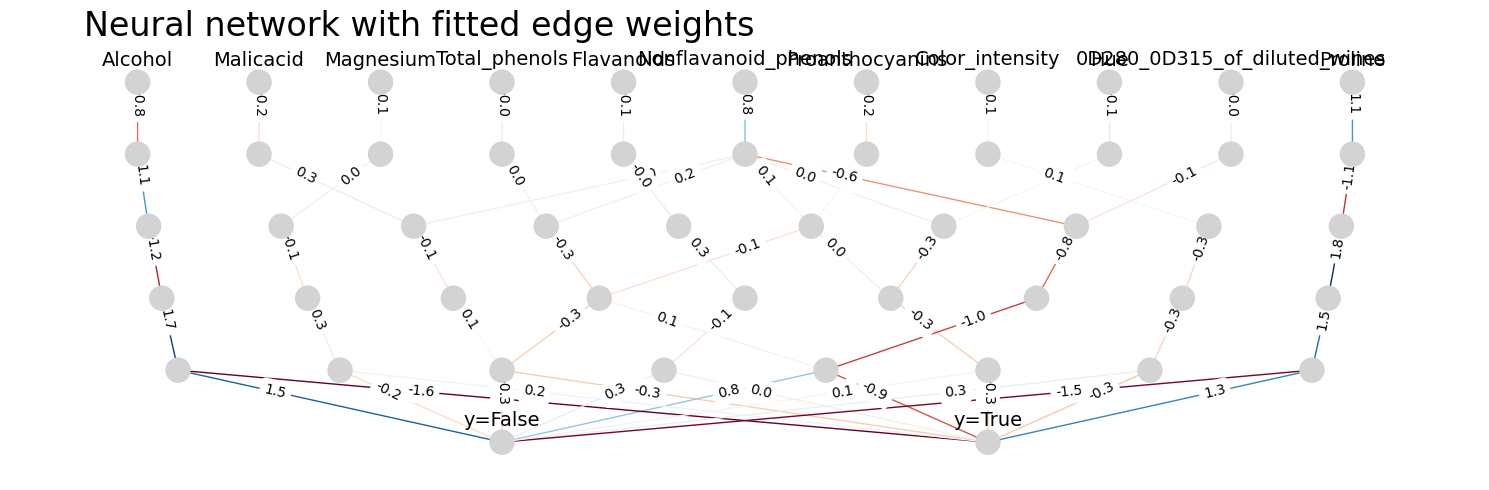

In [44]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

## SECOND DATASET

In [88]:
wine_quality = fetch_ucirepo(id=186) 

X = wine_quality.data.features 
y = wine_quality.data.targets 

In [89]:
#changing index from integers to strings

p = inflect.engine()

custom_index = [p.number_to_words(i+1).capitalize() for i in range(len(X))]
X.index = custom_index
y.index = custom_index

In [90]:
#binarization by median value of each column, including target column

for col in X.columns:
    median_val = X[col].median()
    X.loc[:, col] = X[col] >= median_val

median_val = y['quality'].median()
y.loc[:, 'quality'] = y['quality'] >= median_val

In [91]:
#shuffling the whole dataset and picking 4200 rows

combined_df = pd.concat([X, y], axis=1)
shuffled_df = shuffle(combined_df)
selected_df = shuffled_df.iloc[:4200]
X = selected_df.drop(columns=['quality'], axis=1)
y = selected_df['quality']

In [92]:
#dropping some features

X = X.drop(columns = ['free_sulfur_dioxide', 'pH', 'sulphates'])

In [93]:
y.value_counts()

True     2639
False    1561
Name: quality, dtype: int64

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [116]:
K_train = FormalContext(data=X_train.values, target=y_train.values, attribute_names=X_train.columns)
K_train

FormalContext (2940 objects, 8 attributes, 12060 connections)
    |fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|total_sulfur_dioxide|density|alcohol|
0   |             |               X|          X|             X|         |                   X|      X|       |
1   |            X|                |          X|              |        X|                    |      X|      X|
2   |             |                |           |             X|         |                   X|       |      X|
3   |            X|               X|           |             X|        X|                   X|      X|       |
4   |             |                |          X|             X|         |                   X|       |      X|
5   |            X|                |           |             X|         |                   X|       |      X|
6   |            X|                |           |             X|        X|                    |      X|       |
7   |             |               X|          X|  

In [117]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

238

In [118]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    f1 = f1_score(y_train, y_preds, average='weighted')
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1
    c.measures = frozendict(updated_measures)

In [119]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:5])

In [120]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [121]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [122]:
descr = {'smooth', 'green', 'oval'}

traced = cn.trace_description(descr, include_targets=False)

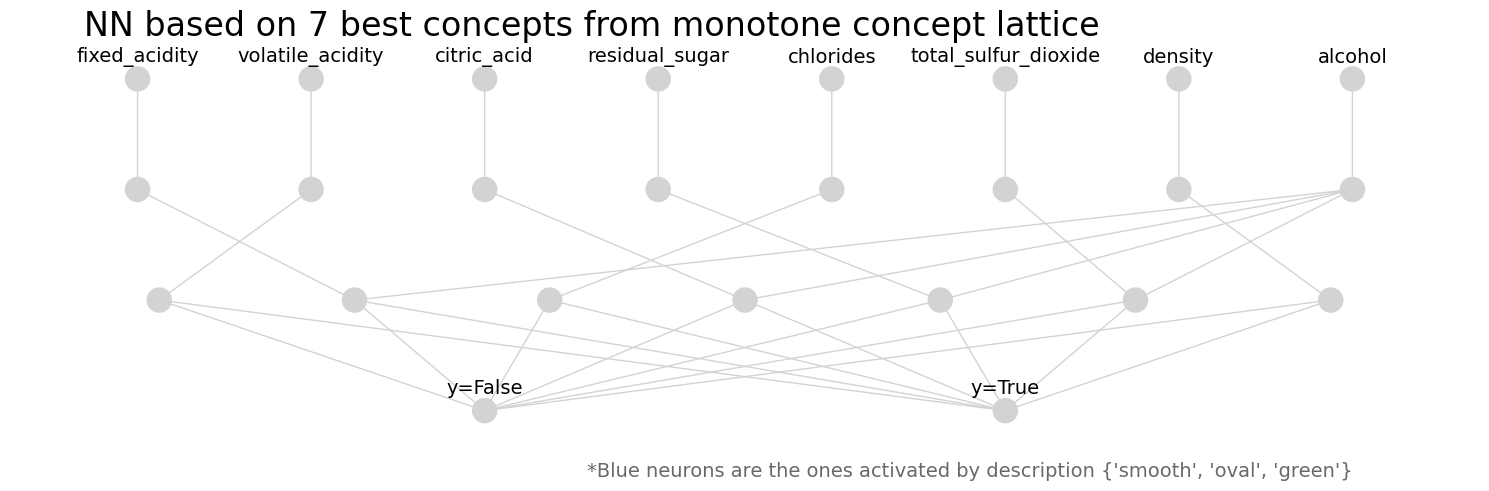

In [123]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [124]:
cn.fit(X_train, y_train)

In [125]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)
print('f1 score', f1_score(y_test.values, cn.predict(X_test).numpy()))
print('accuracy score', accuracy_score(y_test.values, cn.predict(X_test).numpy()))

Class prediction [1 1 1 ... 1 1 1]
Class prediction with probabilities [[0.33524486 0.6647551 ]
 [0.18220755 0.8177924 ]
 [0.33524486 0.6647551 ]
 ...
 [0.18002641 0.8199736 ]
 [0.33197543 0.66802454]
 [0.33524486 0.6647551 ]]
True class [ True  True  True ...  True False False]
f1 score 0.7872954764196344
accuracy score 0.6492063492063492


In [126]:
edge_weights = cn.edge_weights_from_network()

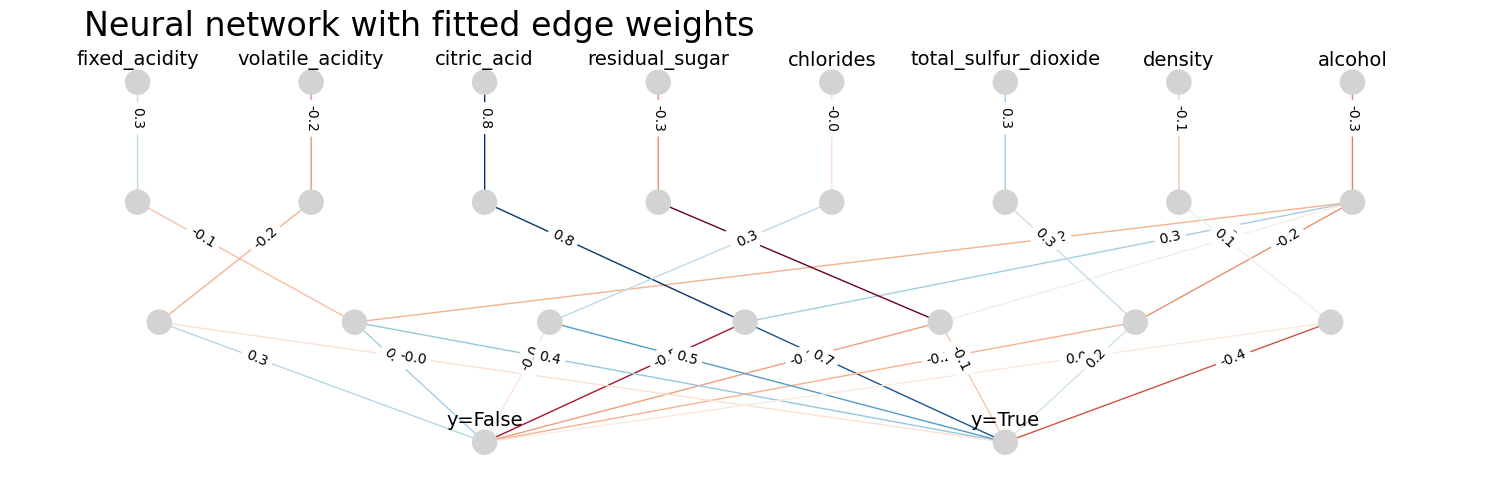

In [127]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

## THIRD DATASET

In [166]:
adult = fetch_ucirepo(id=2) 
X = adult.data.features 
y = adult.data.targets 

In [167]:
X['workclass'] = X['workclass'].fillna('?')
X['occupation'] = X['occupation'].fillna('?')
X['native-country'] = X['native-country'].fillna('?')

In [168]:
#binarization of target column and features
#categorical features binarized by mode
#numerical by median

y['income'] = y['income'] == '<=50K'

def convert_to_bool(column):
    if column.dtype == 'object':
        mode = column.mode()[0]
        return column == mode
    else:
        median = column.median()
        return column >= median

X = X.iloc[:, 1:].apply(convert_to_bool)

In [169]:
X = X.drop(columns = ['education-num', 'fnlwgt'])

In [170]:
#shuffling the whole dataset and picking 60000 rows

combined_df = pd.concat([X, y], axis=1)
shuffled_df = shuffle(combined_df)
selected_df = shuffled_df.iloc[:60000]
X = selected_df.drop(columns=['income'], axis=1)
y = selected_df['income']

In [171]:
#changing index from integers to strings

p = inflect.engine()

custom_index = [p.number_to_words(i+1).capitalize() for i in range(len(X))]
X.index = custom_index
y.index = custom_index

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [173]:
K_train = FormalContext(data=X_train.values, target=y_train.values, attribute_names=X_train.columns)
K_train

FormalContext (34189 objects, 11 attributes, 245694 connections)
     |workclass|education|marital-status|occupation|relationship|...|sex|capital-gain|capital-loss|hours-per-week|native-country|
0    |        X|        X|             X|          |           X|...|  X|           X|           X|             X|             X|
1    |         |         |              |          |            |...|   |           X|           X|              |             X|
2    |         |         |              |          |            |...|  X|           X|           X|              |             X|
3    |        X|         |              |          |            |...|  X|           X|           X|             X|             X|
4    |        X|         |             X|          |           X|...|  X|           X|           X|             X|             X|
5    |         |         |             X|          |           X|...|  X|           X|           X|             X|             X|
6    |         |         

In [174]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

353

In [175]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    f1 = f1_score(y_train, y_preds, average='weighted')
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1
    c.measures = frozendict(updated_measures)

In [176]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:10])
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

descr = {'smooth', 'green', 'oval'}

traced = cn.trace_description(descr, include_targets=False)

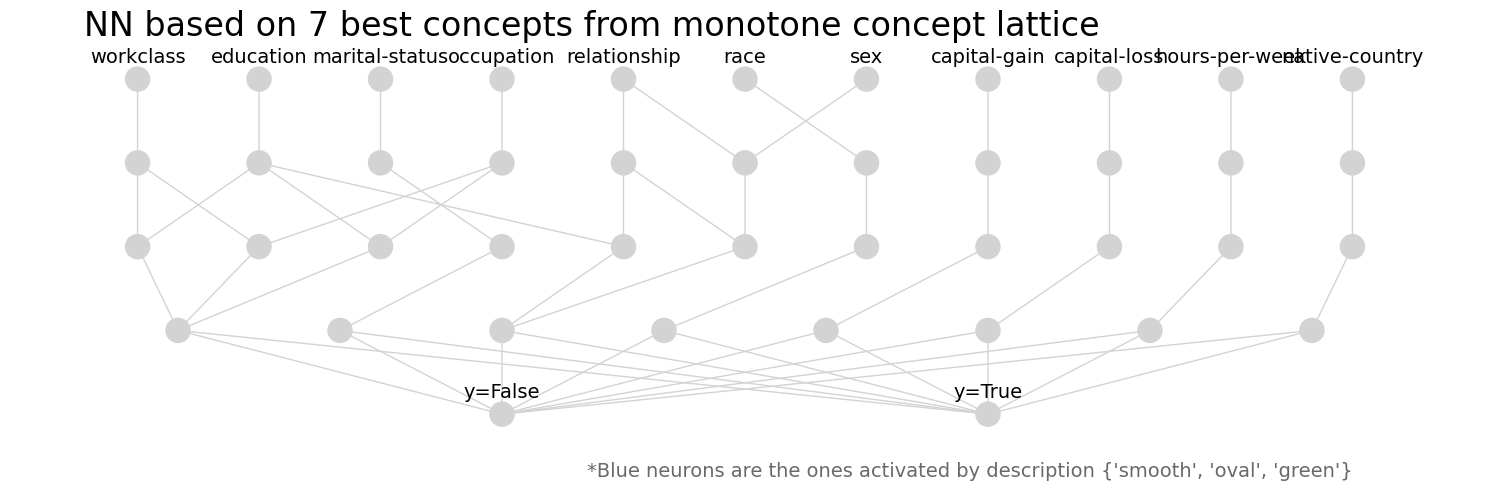

In [177]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [178]:
cn.fit(X_train, y_train)

In [179]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)
print('f1 score', f1_score(y_test.values, cn.predict(X_test).numpy()))
print('accuracy score', accuracy_score(y_test.values, cn.predict(X_test).numpy()))

Class prediction [1 0 0 ... 1 1 0]
Class prediction with probabilities [[0.34691545 0.6530845 ]
 [0.7876563  0.2123437 ]
 [0.7876563  0.2123437 ]
 ...
 [0.34691545 0.6530845 ]
 [0.34691545 0.6530845 ]
 [0.7876563  0.2123437 ]]
True class [False False False ... False  True False]
f1 score 0.6475007761564731
accuracy score 0.6125708046133898


In [180]:
edge_weights = cn.edge_weights_from_network()

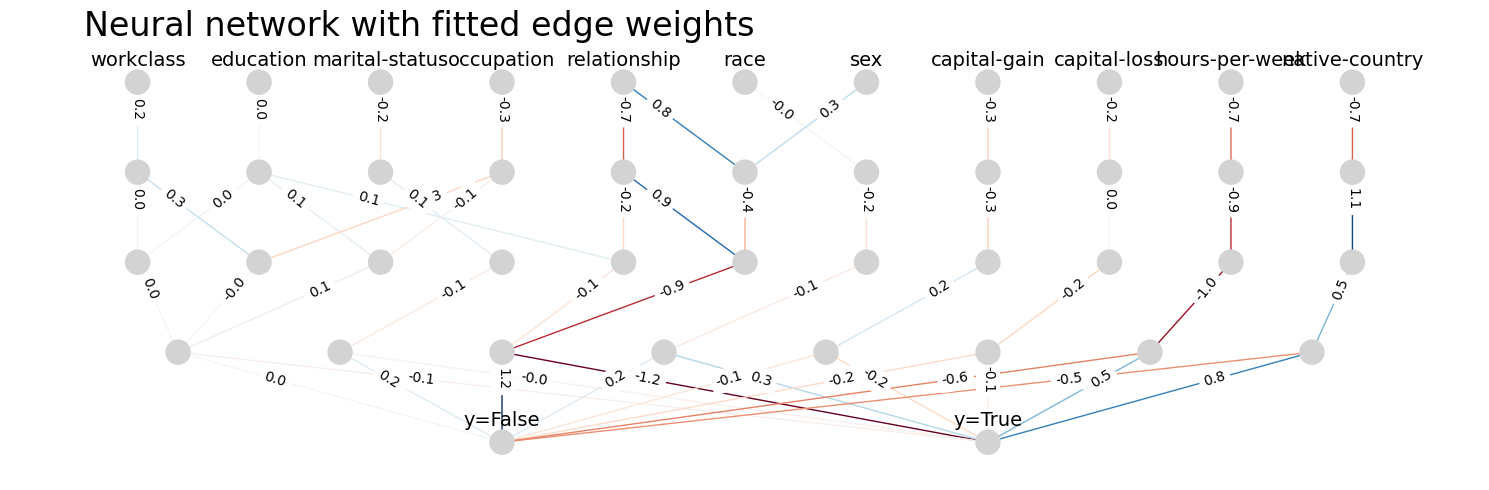

In [181]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()